In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras-multi-head
!pip install keras-self-attention

In [3]:
import keras
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

import numpy as np
import os
import sys

import wave
import copy
import math

import keras

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Embedding, Convolution1D, Dropout, Bidirectional, Conv2D, MaxPooling2D, Conv1D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer




import tensorflow as tf
#from model import AttentionResNet
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [ ]:
%cd /content/drive/MyDrive/PROJECT/codes

In [5]:
from features import *
from helper import *

In [6]:
code_path = "/content/drive/MyDrive/PROJECT/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [7]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [8]:
mocap_head = []
counter = 0
for ses_mod in data2:
    x_head = ses_mod['mocap_head']
    if(x_head.shape != (200,6)):
        x_head = np.zeros((200,6))  
    x_head[np.isnan(x_head)]=0
    mocap_head.append( x_head )
    
mocap_head = np.array(mocap_head)
mocap_head.shape

(4936, 200, 6)

In [9]:
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
    
Y = label_binarize(Y,emotions_used)

Y.shape

(4936, 4)

In [10]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [11]:
xtrain_mocap_head = mocap_head[:3838]
xtest_mocap_head = mocap_head[3838:]
ytrain_mocap_head = Y[:3838]
ytest_mocap_head = Y[3838:]

print(xtrain_mocap_head.shape)
print(xtest_mocap_head.shape)

print(ytrain_mocap_head.shape)
print(xtest_mocap_head.shape)

(3838, 200, 6)
(1098, 200, 6)
(3838, 4)
(1098, 200, 6)


#**Model_Head 1**

In [12]:
def gru_model_head1():
    model = Sequential()
    model.add(GRU(512, return_sequences=True, input_shape=(200, 6)))
    model.add(GRU(256, activation='relu', return_sequences=True))
    model.add(GRU(128, activation='relu', return_sequences=False))
  
  
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model

In [13]:
model = gru_model_head1()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 200, 512)          798720    
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 256)          591360    
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [14]:
hist = model.fit(xtrain_mocap_head, ytrain_mocap_head, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_head, ytest_mocap_head))

Epoch 1/50
39/39 [==============================] - 36s 692ms/step - loss: 1.3738 - accuracy: 0.3225 - val_loss: 1.3651 - val_accuracy: 0.3470
Epoch 2/50
39/39 [==============================] - 26s 677ms/step - loss: 1.3270 - accuracy: 0.3754 - val_loss: 1.3662 - val_accuracy: 0.3479
Epoch 3/50
39/39 [==============================] - 27s 693ms/step - loss: 1.3088 - accuracy: 0.3893 - val_loss: 1.3622 - val_accuracy: 0.3543
Epoch 4/50
39/39 [==============================] - 26s 674ms/step - loss: 1.3010 - accuracy: 0.4003 - val_loss: 1.3499 - val_accuracy: 0.3670
Epoch 5/50
39/39 [==============================] - 27s 683ms/step - loss: 1.2849 - accuracy: 0.4265 - val_loss: 1.3582 - val_accuracy: 0.3652
Epoch 6/50
39/39 [==============================] - 27s 693ms/step - loss: 1.2656 - accuracy: 0.4260 - val_loss: 1.3532 - val_accuracy: 0.3707
Epoch 7/50
39/39 [==============================] - 27s 684ms/step - loss: 1.2639 - accuracy: 0.4271 - val_loss: 1.3515 - val_accuracy: 0.3506

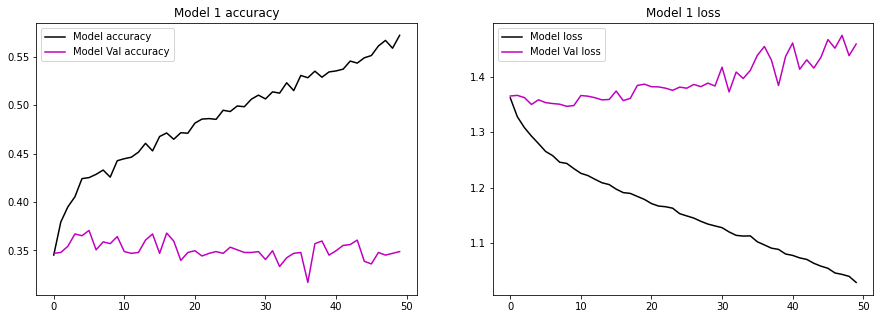

In [15]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [16]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [17]:
loss, acc = model.evaluate(xtrain_mocap_head, ytrain_mocap_head,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_head, ytest_mocap_head,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.99598 dan Training Accuracy 58.36%
Validation Loss 1.45861 dan Validation Accuracy 34.88%


In [18]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.76      0.29      0.42       933
         exc       0.80      0.26      0.39       742
         neu       0.73      0.30      0.42      1324
         sad       0.68      0.56      0.61       839

   micro avg       0.72      0.34      0.47      3838
   macro avg       0.74      0.35      0.46      3838
weighted avg       0.74      0.34      0.45      3838
 samples avg       0.34      0.34      0.34      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.24      0.14      0.18       170
         exc       0.45      0.10      0.16       299
         neu       0.36      0.14      0.20       384
         sad       0.30      0.18      0.23       245

   micro avg       0.33      0.14      0.20      1098
   macro avg       0.34      0.14      0.19      1098
weighted avg       0.35      0.14      0.19      1098
 samples avg       0.14      0.14      0.14      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


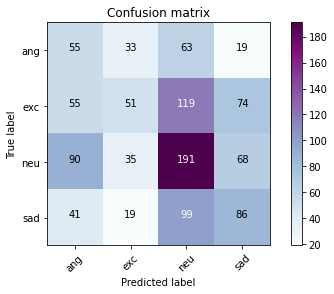

In [21]:
import itertools
Y_pred = model.predict(xtest_mocap_head)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_head,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_Head 2**

In [22]:
def gru_model_head2():
  model = Sequential()
  model.add(GRU(512, activation='relu', return_sequences=True, input_shape=(200, 6)))
  model.add(SeqSelfAttention(attention_activation='relu'))
  model.add(GRU(256, activation='relu', return_sequences=True))
  model.add(SeqSelfAttention(attention_activation='relu'))
  model.add(GRU(128, activation='relu', return_sequences=False))

  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(4))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

  return model

In [23]:
model = gru_model_head2()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 200, 512)          798720    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 512)         32833     
_________________________________________________________________
gru_4 (GRU)                  (None, None, 256)         591360    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_2 (Activation)    (None, 256)              

In [24]:
hist = model.fit(xtrain_mocap_head, ytrain_mocap_head, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_head, ytest_mocap_head))

Epoch 1/50
39/39 [==============================] - 43s 1s/step - loss: 1.3582 - accuracy: 0.3552 - val_loss: 1.3421 - val_accuracy: 0.3689
Epoch 2/50
39/39 [==============================] - 38s 980ms/step - loss: 1.2807 - accuracy: 0.3963 - val_loss: 1.3213 - val_accuracy: 0.3871
Epoch 3/50
39/39 [==============================] - 39s 1s/step - loss: 1.2467 - accuracy: 0.4326 - val_loss: 1.3150 - val_accuracy: 0.3925
Epoch 4/50
39/39 [==============================] - 39s 1s/step - loss: 1.2057 - accuracy: 0.4596 - val_loss: 1.3084 - val_accuracy: 0.4062
Epoch 5/50
39/39 [==============================] - 39s 989ms/step - loss: 1.1857 - accuracy: 0.4662 - val_loss: 1.3473 - val_accuracy: 0.3698
Epoch 6/50
39/39 [==============================] - 39s 1s/step - loss: 1.1751 - accuracy: 0.4663 - val_loss: 1.2908 - val_accuracy: 0.4189
Epoch 7/50
39/39 [==============================] - 39s 994ms/step - loss: 1.1634 - accuracy: 0.4783 - val_loss: 1.3020 - val_accuracy: 0.3980
Epoch 8/50


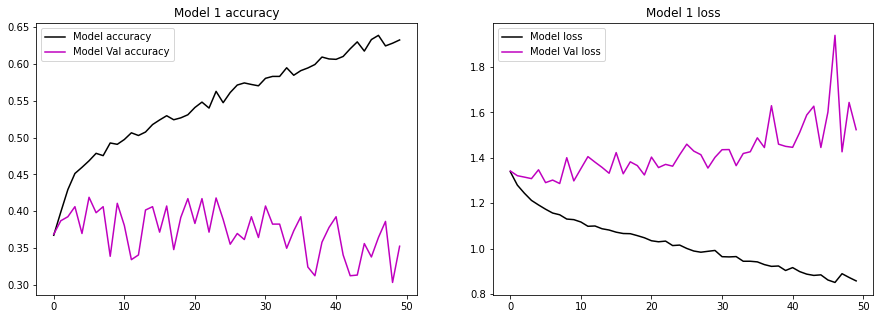

In [25]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [26]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [27]:
loss, acc = model.evaluate(xtrain_mocap_head, ytrain_mocap_head,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_head, ytest_mocap_head,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.88183 dan Training Accuracy 60.01%
Validation Loss 1.52361 dan Validation Accuracy 35.25%


In [28]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.84      0.36      0.51       933
         exc       0.57      0.75      0.65       742
         neu       0.74      0.36      0.48      1324
         sad       0.72      0.56      0.63       839

   micro avg       0.69      0.48      0.57      3838
   macro avg       0.72      0.51      0.57      3838
weighted avg       0.73      0.48      0.55      3838
 samples avg       0.48      0.48      0.48      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.28      0.22      0.24       170
         exc       0.40      0.34      0.37       299
         neu       0.48      0.19      0.28       384
         sad       0.51      0.27      0.35       245

   micro avg       0.42      0.25      0.32      1098
   macro avg       0.42      0.26      0.31      1098
weighted avg       0.43      0.25      0.31      1098
 samples avg       0.25      0.25      0.25      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


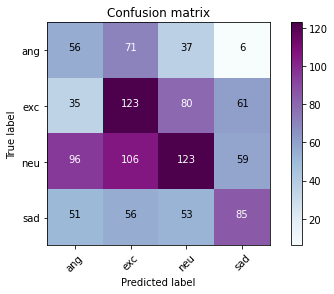

In [31]:
import itertools
Y_pred = model.predict(xtest_mocap_head)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_head,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_Head 3**

In [32]:
def gru_model_head3():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 6)))
    model.add(Bidirectional(GRU(256, activation='relu', return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False)))
  
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    #print(model.summary())

    return model

In [33]:
model = gru_model_head3()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         1597440   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 512)          1969152   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               493056    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [34]:
hist = model.fit(xtrain_mocap_head, ytrain_mocap_head, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_head, ytest_mocap_head))

Epoch 1/50
39/39 [==============================] - 84s 2s/step - loss: 1.4138 - accuracy: 0.3233 - val_loss: 1.3262 - val_accuracy: 0.3670
Epoch 2/50
39/39 [==============================] - 76s 2s/step - loss: 1.2857 - accuracy: 0.3868 - val_loss: 1.3108 - val_accuracy: 0.3953
Epoch 3/50
39/39 [==============================] - 75s 2s/step - loss: 1.2372 - accuracy: 0.4365 - val_loss: 1.3359 - val_accuracy: 0.3925
Epoch 4/50
39/39 [==============================] - 76s 2s/step - loss: 1.1977 - accuracy: 0.4644 - val_loss: 1.3430 - val_accuracy: 0.3816
Epoch 5/50
39/39 [==============================] - 76s 2s/step - loss: 1.1870 - accuracy: 0.4560 - val_loss: 1.3421 - val_accuracy: 0.3661
Epoch 6/50
39/39 [==============================] - 77s 2s/step - loss: 1.1408 - accuracy: 0.4926 - val_loss: 1.3329 - val_accuracy: 0.3716
Epoch 7/50
39/39 [==============================] - 76s 2s/step - loss: 1.1294 - accuracy: 0.4846 - val_loss: 1.3144 - val_accuracy: 0.3880
Epoch 8/50
39/39 [==

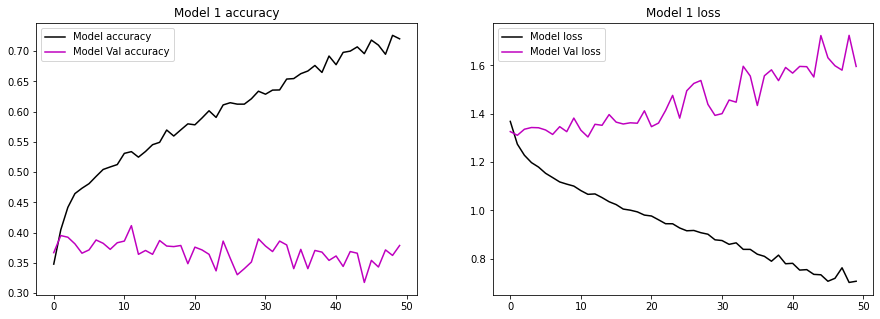

In [35]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [36]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [37]:
loss, acc = model.evaluate(xtrain_mocap_head, ytrain_mocap_head,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_head, ytest_mocap_head,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.65096 dan Training Accuracy 73.87%
Validation Loss 1.59609 dan Validation Accuracy 37.89%


In [38]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.92      0.50      0.65       933
         exc       0.73      0.78      0.75       742
         neu       0.93      0.51      0.66      1324
         sad       0.75      0.79      0.77       839

   micro avg       0.82      0.62      0.71      3838
   macro avg       0.83      0.64      0.71      3838
weighted avg       0.85      0.62      0.70      3838
 samples avg       0.62      0.62      0.62      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.26      0.18      0.21       170
         exc       0.40      0.32      0.35       299
         neu       0.53      0.18      0.27       384
         sad       0.40      0.36      0.38       245

   micro avg       0.40      0.26      0.31      1098
   macro avg       0.40      0.26      0.30      1098
weighted avg       0.42      0.26      0.31      1098
 samples avg       0.26      0.26      0.26      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


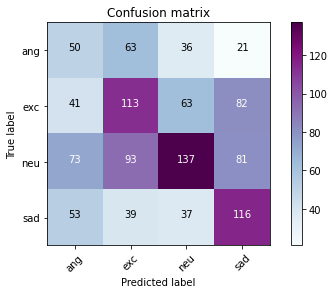

In [41]:
import itertools
Y_pred = model.predict(xtest_mocap_head)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_head,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_Head 4**

In [42]:
def gru_model_head4():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 6)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation='relu', return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False)))
    
   
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])


    #print(model.summary())

    return model

In [43]:
model = gru_model_head4()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 200, 1024)         1597440   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 512)         1969152   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               493056    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [44]:
hist = model.fit(xtrain_mocap_head, ytrain_mocap_head, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_head, ytest_mocap_head))

Epoch 1/50
39/39 [==============================] - 79s 2s/step - loss: 1.3791 - accuracy: 0.3396 - val_loss: 1.3423 - val_accuracy: 0.3552
Epoch 2/50
39/39 [==============================] - 73s 2s/step - loss: 1.2585 - accuracy: 0.4187 - val_loss: 1.3124 - val_accuracy: 0.3880
Epoch 3/50
39/39 [==============================] - 73s 2s/step - loss: 1.2120 - accuracy: 0.4320 - val_loss: 1.2840 - val_accuracy: 0.4171
Epoch 4/50
39/39 [==============================] - 73s 2s/step - loss: 1.2066 - accuracy: 0.4460 - val_loss: 1.3286 - val_accuracy: 0.3798
Epoch 5/50
39/39 [==============================] - 73s 2s/step - loss: 1.1588 - accuracy: 0.4749 - val_loss: 1.3513 - val_accuracy: 0.3634
Epoch 6/50
39/39 [==============================] - 74s 2s/step - loss: 1.1208 - accuracy: 0.4855 - val_loss: 1.3444 - val_accuracy: 0.3661
Epoch 7/50
39/39 [==============================] - 73s 2s/step - loss: 1.1261 - accuracy: 0.4737 - val_loss: 1.3039 - val_accuracy: 0.4098
Epoch 8/50
39/39 [==

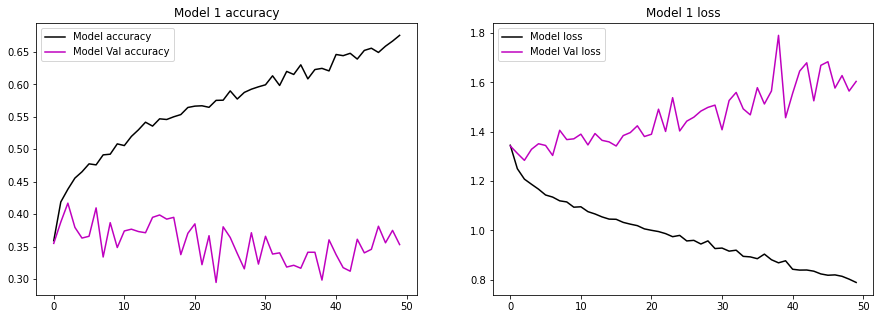

In [45]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [46]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [47]:
loss, acc = model.evaluate(xtrain_mocap_head, ytrain_mocap_head,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_head, ytest_mocap_head,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.80511 dan Training Accuracy 66.02%
Validation Loss 1.60388 dan Validation Accuracy 35.34%


In [48]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.89      0.46      0.61       933
         exc       0.82      0.59      0.69       742
         neu       0.86      0.36      0.51      1324
         sad       0.59      0.77      0.67       839

   micro avg       0.75      0.52      0.61      3838
   macro avg       0.79      0.55      0.62      3838
weighted avg       0.80      0.52      0.60      3838
 samples avg       0.52      0.52      0.52      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_head)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_head, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.25      0.21      0.23       170
         exc       0.49      0.20      0.29       299
         neu       0.50      0.17      0.26       384
         sad       0.35      0.37      0.36       245

   micro avg       0.39      0.23      0.29      1098
   macro avg       0.40      0.24      0.28      1098
weighted avg       0.43      0.23      0.28      1098
 samples avg       0.23      0.23      0.23      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


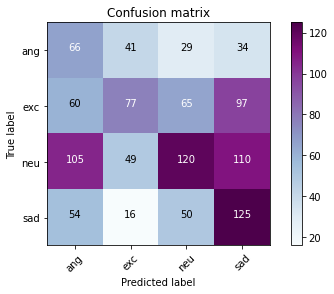

In [51]:
import itertools
Y_pred = model.predict(xtest_mocap_head)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_head,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 